<a href="https://colab.research.google.com/github/mj-codes-web/Mental-Health-Text-Classification/blob/main/Mental_Health_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [4]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/archive.zip'
extraction_path = '/content/unzipped_archive'

# Create the directory if it doesn't exist
os.makedirs(extraction_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"Archive extracted to: {extraction_path}")
print("Contents of the unzipped archive:")
for root, dirs, files in os.walk(extraction_path):
    for name in files:
        print(os.path.join(root, name))
    for name in dirs:
        print(os.path.join(root, name))

Archive extracted to: /content/unzipped_archive
Contents of the unzipped archive:
/content/unzipped_archive/mental_health_combined_test.csv
/content/unzipped_archive/mental_heath_unbanlanced.csv
/content/unzipped_archive/mental_heath_feature_engineered.csv


In [10]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.inspection import permutation_importance

sns.set_theme(style="whitegrid", context="notebook")

%matplotlib inline

np.random.seed(42)

print("Libraries imported successfully")

Libraries imported successfully


In [12]:
path_test = "/content/unzipped_archive/mental_health_combined_test.csv"
path_unbalanced = "/content/unzipped_archive/mental_heath_unbanlanced.csv"
path_engineered = "/content/unzipped_archive/mental_heath_feature_engineered.csv"

df_test = pd.read_csv(path_test)
df_unbalanced = pd.read_csv(path_unbalanced)
df_engineered = pd.read_csv(path_engineered)

print("Test Dataset Shape:", df_test.shape)
print("Unbalanced Dataset Shape:", df_unbalanced.shape)
print("Engineered Dataset Shape:", df_engineered.shape)

print("Test Dataset Head:")
print(df_test.head(), "\n")

print("Unbalanced Dataset Head:")
print(df_unbalanced.head(), "\n")

print("Engineered Dataset Head:")
print(df_engineered.head())

Test Dataset Shape: (992, 2)
Unbalanced Dataset Shape: (49612, 3)
Engineered Dataset Shape: (49612, 21)
Test Dataset Head:
                                                text   status
0  i don't understand whats wrong with me. i don'...  Anxiety
1  usually when i have anxiety just chatting with...  Anxiety
2  well, i've had anxiety and panic syndrome for ...  Anxiety
3  for the most minimal of things, like standing ...  Anxiety
4  i stay away from family and live with my roomm...  Anxiety 

Unbalanced Dataset Head:
   Unique_ID                                               text   status
0        0.0                                         oh my gosh  Anxiety
1        1.0  trouble sleeping, confused mind, restless hear...  Anxiety
2        2.0  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3        3.0  I've shifted my focus to something else but I'...  Anxiety
4        4.0  I'm restless and restless, it's been a month n...  Anxiety 

Engineered Dataset Head:
   Unique_ID 

In [13]:
print("Missing values in Engineered Dataset:")
print(df_engineered.isnull().sum(), "\n")

df_engineered = df_engineered.drop_duplicates()

print("Engineered Dataset shape after dropping duplicates:", df_engineered.shape)

Missing values in Engineered Dataset:
Unique_ID               9600
text                       0
status                     0
text_length             9600
word_count              9600
num_urls                9600
num_emojis              9600
num_special_chars       9600
num_excess_punct        9600
avg_word_length         9600
stopword_ratio          9600
type_token_ratio        9600
polarity                9600
subjectivity            9600
noun_ratio              9600
verb_ratio              9600
adj_ratio               9600
adv_ratio               9600
has_suicidal_keyword    9600
has_stress_keyword      9600
has_help_keyword        9600
dtype: int64 

Engineered Dataset shape after dropping duplicates: (49612, 21)


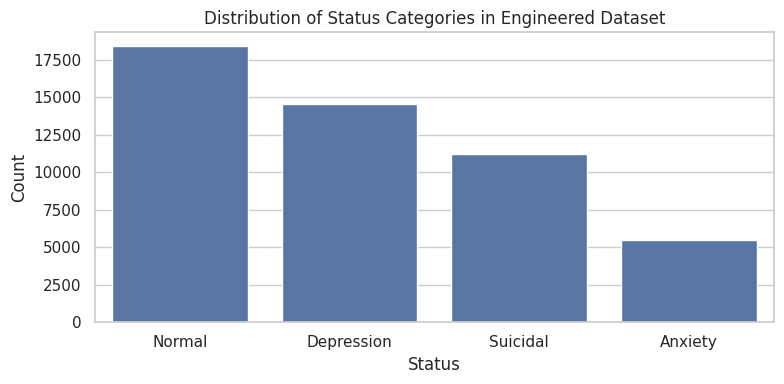

In [14]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df_engineered, x="status", order=df_engineered["status"].value_counts().index)
plt.title("Distribution of Status Categories in Engineered Dataset")
plt.xlabel("Status")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

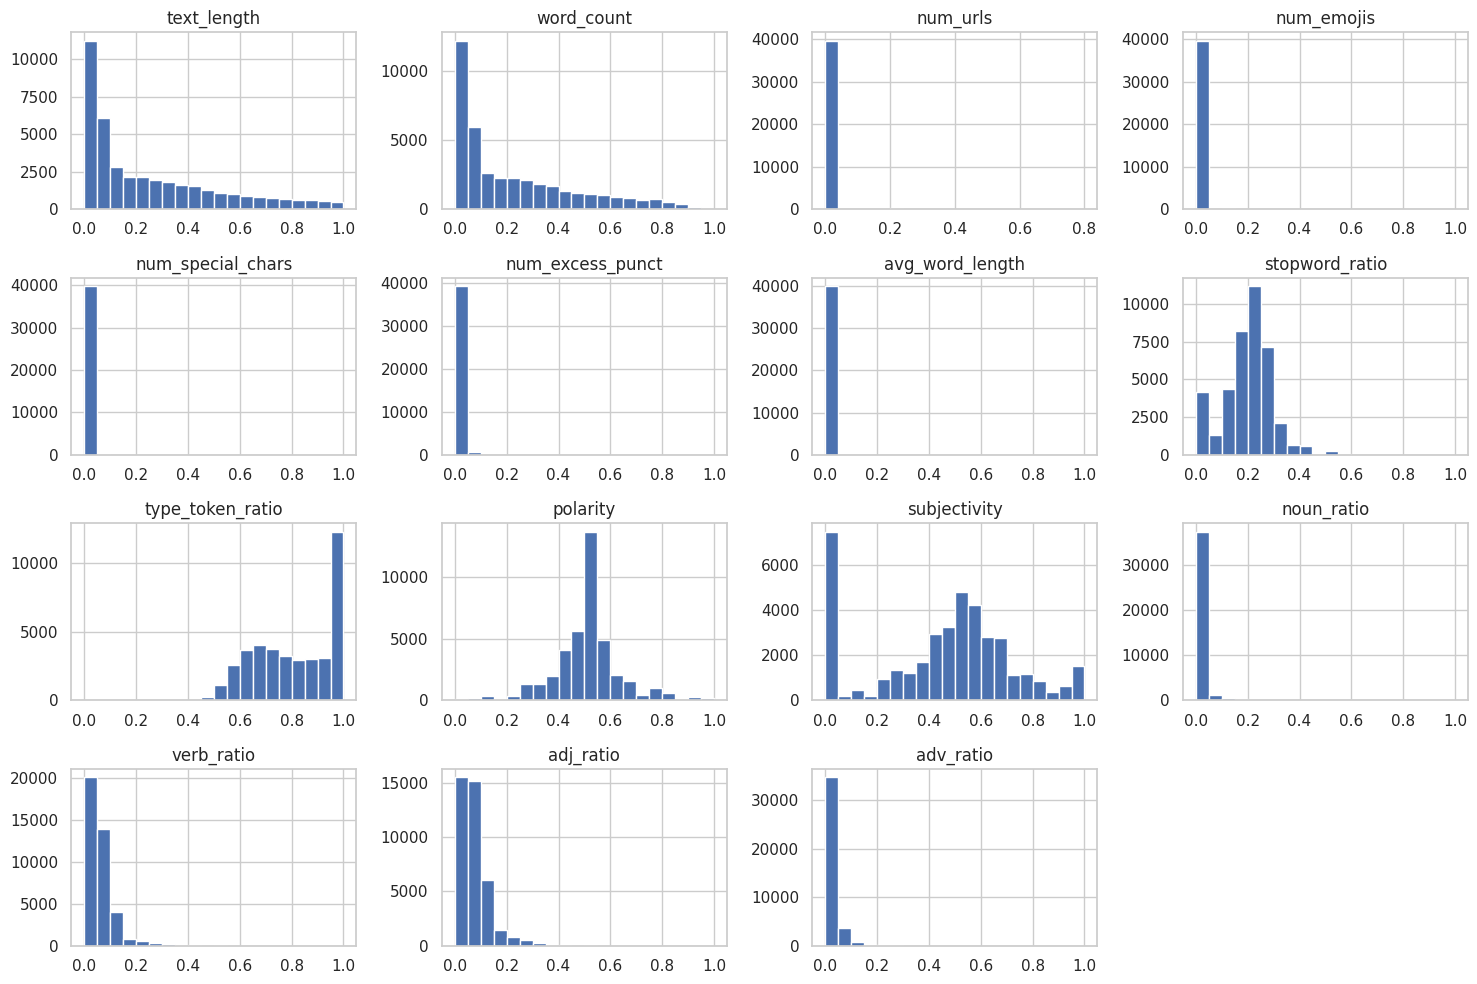

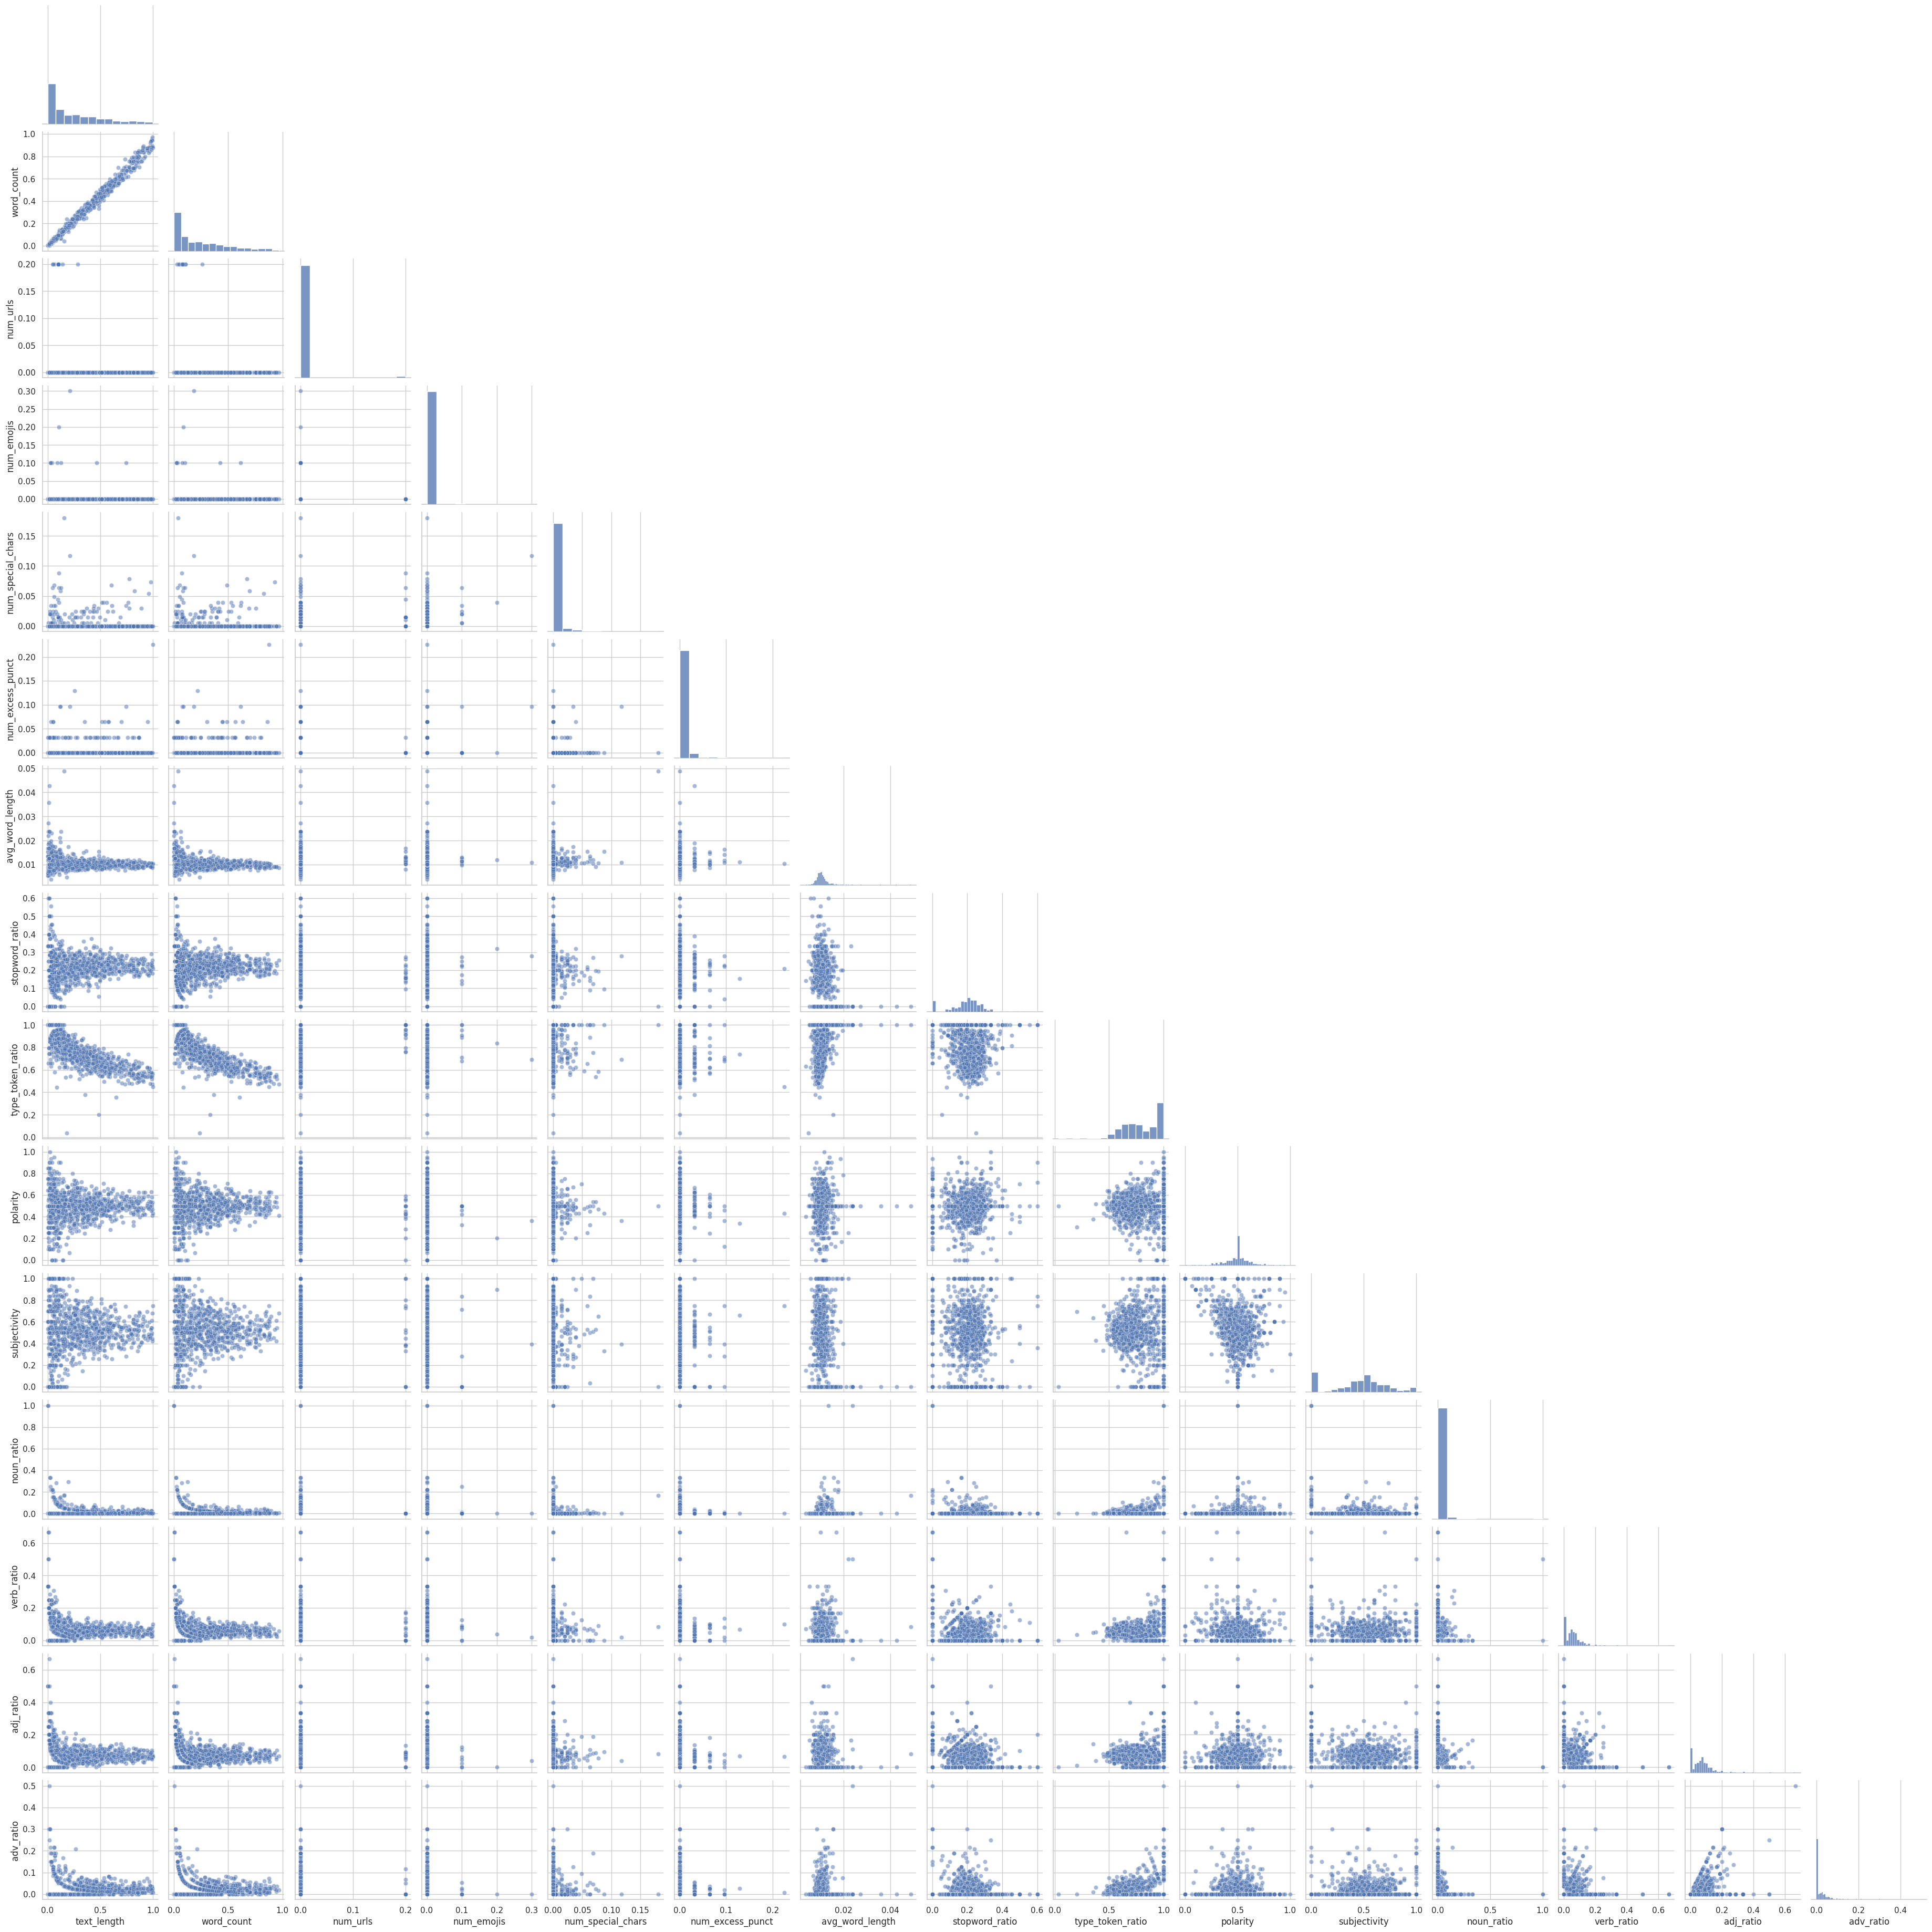

In [15]:
numeric_features = [
    "text_length",
    "word_count",
    "num_urls",
    "num_emojis",
    "num_special_chars",
    "num_excess_punct",
    "avg_word_length",
    "stopword_ratio",
    "type_token_ratio",
    "polarity",
    "subjectivity",
    "noun_ratio",
    "verb_ratio",
    "adj_ratio",
    "adv_ratio",
]

numeric_features = [col for col in numeric_features if col in df_engineered.columns]

df_engineered[numeric_features].hist(figsize=(15, 10), bins=20, layout=(4, 4))
plt.tight_layout()
plt.show()

pairplot_data = df_engineered[numeric_features].dropna()
if len(pairplot_data) > 1000:
    pairplot_data = pairplot_data.sample(1000, random_state=42)

sns.pairplot(pairplot_data, corner=True, plot_kws={"alpha": 0.5}, diag_kind="hist")
plt.show()

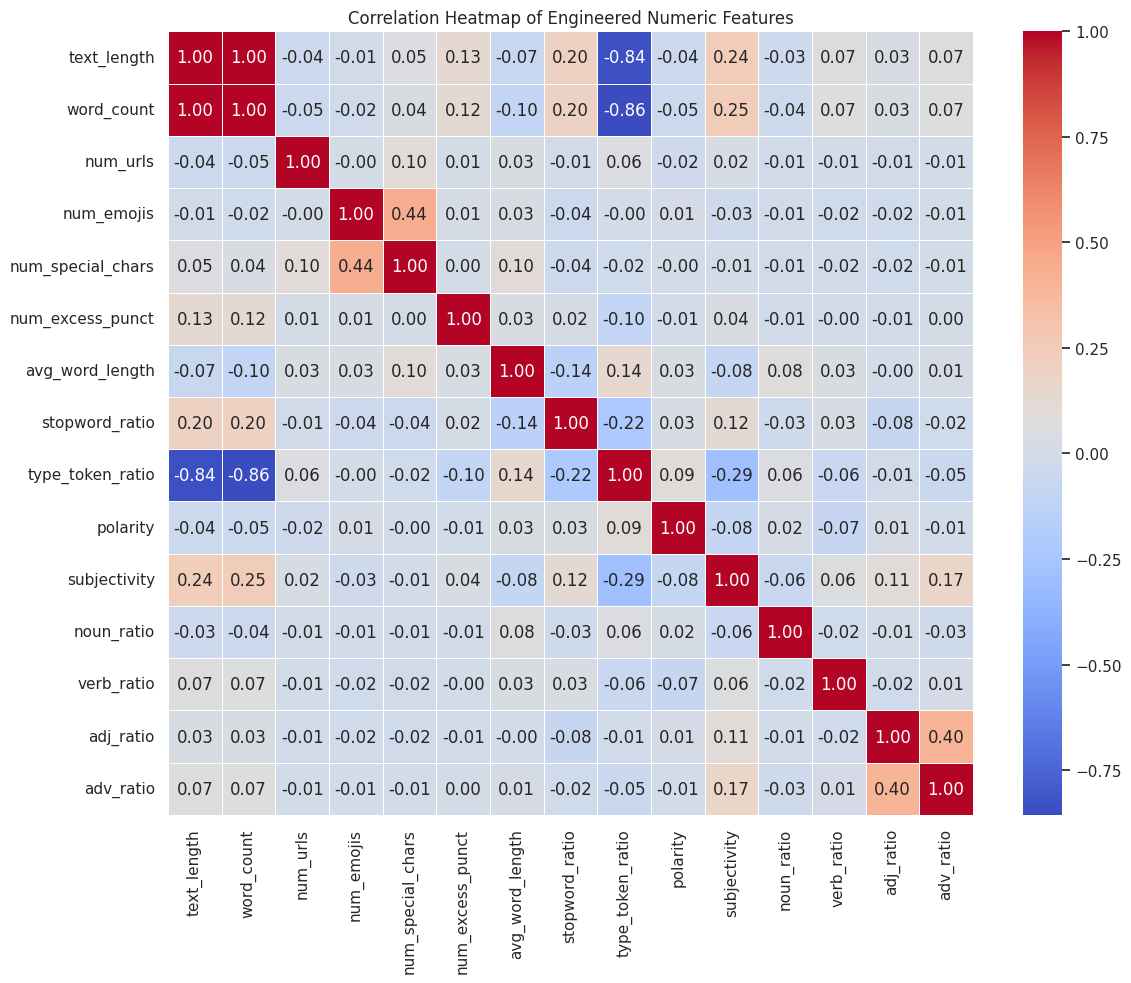

In [16]:
numeric_df = df_engineered[numeric_features].select_dtypes(include=[np.number])

if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(12, 10))
    corr_matrix = numeric_df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Heatmap of Engineered Numeric Features")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns for correlation heatmap.")

In [17]:
feature_cols = numeric_features

X = df_engineered[feature_cols].fillna(0)
y = df_engineered["status"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded,
)

In [18]:
clf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1,
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

Accuracy: 58.56%
Balanced Accuracy: 56.21%

Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.32      0.64      0.42      1101
  Depression       0.56      0.58      0.57      2901
      Normal       0.81      0.78      0.80      3678
    Suicidal       0.47      0.24      0.32      2243

    accuracy                           0.59      9923
   macro avg       0.54      0.56      0.53      9923
weighted avg       0.61      0.59      0.58      9923



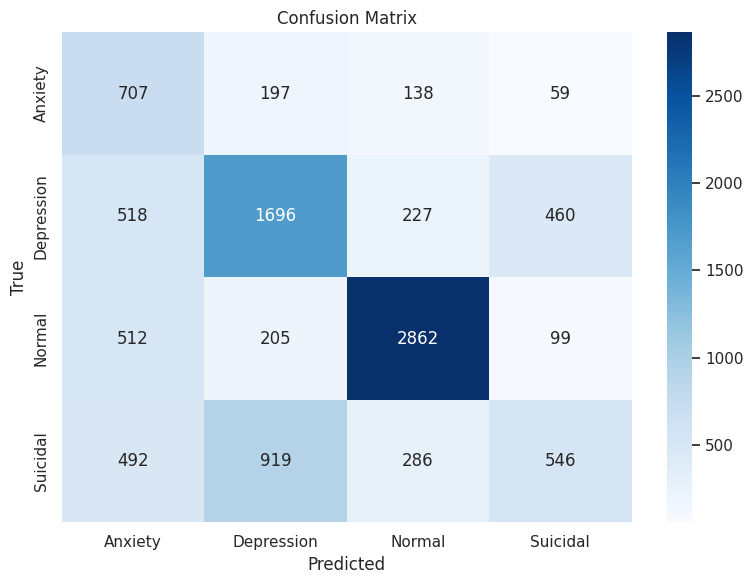

ROC curve is typically plotted for binary classification. Skipping ROC curve for multiclass.


In [19]:
accuracy = accuracy_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Balanced Accuracy: {:.2f}%".format(balanced_acc * 100))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

if len(le.classes_) == 2:
    y_scores = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label="ROC curve (area = {:.2f})".format(roc_auc))
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
else:
    print("ROC curve is typically plotted for binary classification. Skipping ROC curve for multiclass.")

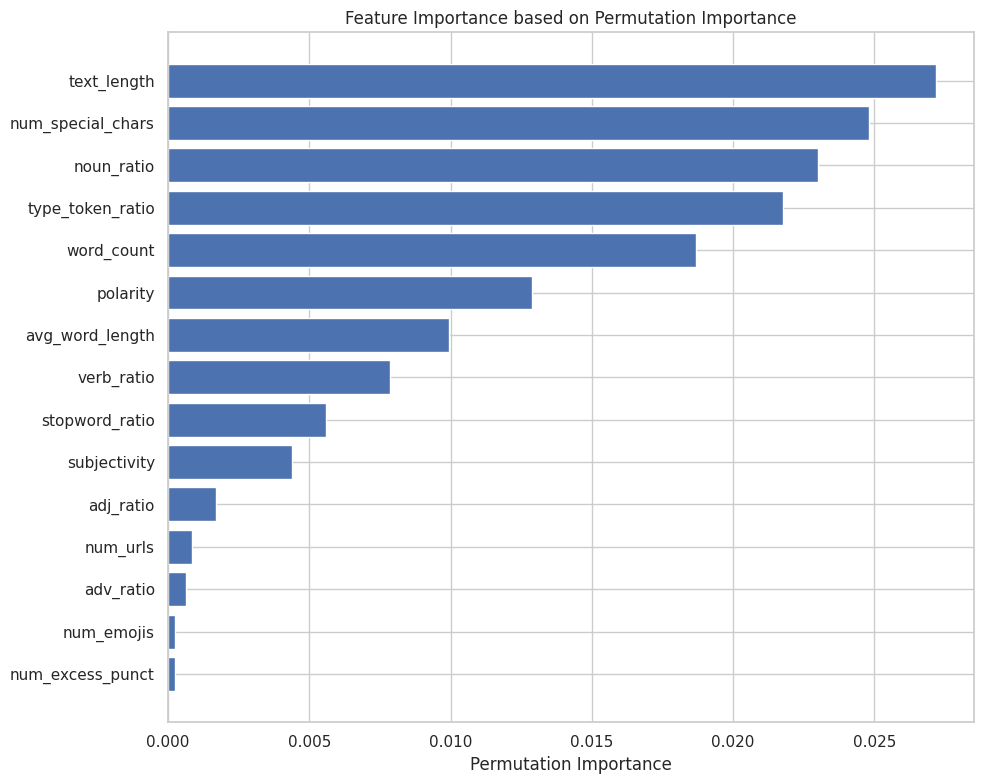

In [20]:
result = permutation_importance(
    clf,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
)

sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 8))
plt.barh(np.array(feature_cols)[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance based on Permutation Importance")
plt.tight_layout()
plt.show()

In [21]:
print("Analysis complete. The predictive model and visualizations provide a solid baseline for further investigation into mental health text data.")

Analysis complete. The predictive model and visualizations provide a solid baseline for further investigation into mental health text data.


In [24]:
import pandas as pd
import joblib
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

df = pd.read_csv("/content/unzipped_archive/mental_heath_unbanlanced.csv")
df = df.dropna(subset=["text", "status"]).drop_duplicates()

model = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_features=30000)),
    ("clf", LogisticRegression(max_iter=2000))
])

model.fit(df["text"].astype(str), df["status"].astype(str))

joblib.dump(model, "mh_model.pkl")
print("Saved mh_model.pkl")

Saved mh_model.pkl
